In [2]:
# data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns


#model selection
from tensorflow.keras.models import Model, load_model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Input, Add,Dropout, Dense, Activation, ZeroPadding2D, \
BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalAveragePooling2D
#preprocess.
from keras.preprocessing.image import ImageDataGenerator

#dl libraraies
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.utils import to_categorical

# specifically for cnn
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
import tensorflow as tf
import random as rn

# specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
import cv2                  
import numpy as np  
from tqdm import tqdm
import os                   
from random import shuffle  
from zipfile import ZipFile
import PIL
import PIL.Image

import glob   
import shutil


# Data preprocessing

In [3]:
images=[]
X = []

In [4]:
def read_data(flower_type):
    DIR = '/' + flower_type + '/'
    current_dir = os.curdir + "/Flowers" + DIR

    for img in tqdm(os.listdir(current_dir)):
        path = os.path.join(current_dir,img)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        images.append(img)        
        img = cv2.resize(img, (224,224))
        X.append(np.array(img))
        
        
        

In [5]:
classes = ['Tana', 'Rosy', 'Pingpong','Lisianthus', 'Hydrangeas', 'Chrysanthemum', 'Calimerio', 'Babi']

for item in classes:
    read_data(item)

100%|███████████████████████████████████████████████████████████████████████████████| 931/931 [00:01<00:00, 786.90it/s]


In [6]:
X = np.asarray(X, dtype=np.float32)

X = X.astype('float32') / 255.

In [163]:
print(X.shape)

(3696, 224, 224, 3)


In [188]:
training_dir = os.curdir + '/Train'

# Test data dir
testing_dir = os.curdir + '/Test'

data_gen = ImageDataGenerator(rescale = 1./255)
train_generator = data_gen.flow_from_directory(training_dir, (224,224), batch_size=64, class_mode='input',shuffle=True)
valid_generator = data_gen.flow_from_directory(testing_dir, (224,224), batch_size=64, class_mode='input', shuffle=True)

Found 3696 images belonging to 8 classes.
Found 925 images belonging to 8 classes.


# Base model

In [221]:
input_img = Input(shape=(224, 224, 3))

x = Conv2D(8, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same', name=  'encoder')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

base_autoencoder = Model(input_img, decoded)
base_autoencoder.compile(optimizer='adam', loss='mse')
base_autoencoder.summary()

Model: "model_61"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_53 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_265 (Conv2D)         (None, 224, 224, 8)       224       
                                                                 
 max_pooling2d_87 (MaxPoolin  (None, 112, 112, 8)      0         
 g2D)                                                            
                                                                 
 conv2d_266 (Conv2D)         (None, 112, 112, 16)      1168      
                                                                 
 max_pooling2d_88 (MaxPoolin  (None, 56, 56, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_267 (Conv2D)         (None, 56, 56, 32)        464

In [222]:
history = base_autoencoder.fit(
        train_generator,
        steps_per_epoch=train_generator.n//64,
        validation_data=valid_generator,
        validation_steps=valid_generator.n//64,
        epochs=10)

Epoch 1/10
57/57 [==============================] - 107s 2s/step - loss: 0.0524 - val_loss: 0.0278
Epoch 2/10
57/57 [==============================] - 104s 2s/step - loss: 0.0238 - val_loss: 0.0219
Epoch 3/10
57/57 [==============================] - 107s 2s/step - loss: 0.0188 - val_loss: 0.0171
Epoch 4/10
57/57 [==============================] - 105s 2s/step - loss: 0.0158 - val_loss: 0.0152
Epoch 5/10
57/57 [==============================] - 106s 2s/step - loss: 0.0146 - val_loss: 0.0142
Epoch 6/10
57/57 [==============================] - 104s 2s/step - loss: 0.0140 - val_loss: 0.0138
Epoch 7/10
57/57 [==============================] - 104s 2s/step - loss: 0.0135 - val_loss: 0.0134
Epoch 8/10
57/57 [==============================] - 107s 2s/step - loss: 0.0131 - val_loss: 0.0132
Epoch 9/10
57/57 [==============================] - 106s 2s/step - loss: 0.0128 - val_loss: 0.0127
Epoch 10/10
57/57 [==============================] - 106s 2s/step - loss: 0.0125 - val_loss: 0.0124


In [224]:
def create_autoencoder(learning_rate):
    input_img = Input(shape=(224, 224, 3))

    x = Conv2D(8, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same', name=  'encoder')(x)


    x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
    
    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer=Adam(learning_rate), loss='mse')
    return autoencoder

Epoch 1/10
57/57 [==============================] - 103s 2s/step - loss: 0.0838 - val_loss: 0.0767
Epoch 2/10
57/57 [==============================] - 102s 2s/step - loss: 0.0600 - val_loss: 0.0471
Epoch 3/10
57/57 [==============================] - 104s 2s/step - loss: 0.0388 - val_loss: 0.0331
Epoch 4/10
57/57 [==============================] - 106s 2s/step - loss: 0.0285 - val_loss: 0.0259
Epoch 5/10
57/57 [==============================] - 106s 2s/step - loss: 0.0241 - val_loss: 0.0230
Epoch 6/10
57/57 [==============================] - 105s 2s/step - loss: 0.0218 - val_loss: 0.0209
Epoch 7/10
57/57 [==============================] - 104s 2s/step - loss: 0.0200 - val_loss: 0.0195
Epoch 8/10
57/57 [==============================] - 102s 2s/step - loss: 0.0188 - val_loss: 0.0186
Epoch 9/10
57/57 [==============================] - 102s 2s/step - loss: 0.0181 - val_loss: 0.0181
Epoch 10/10
57/57 [==============================] - 104s 2s/step - loss: 0.0177 - val_loss: 0.0176


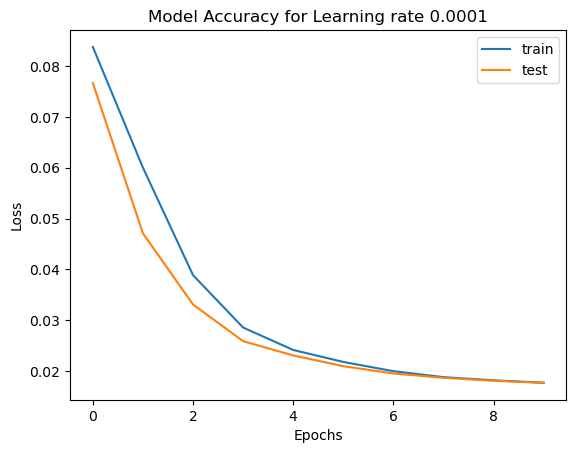

Epoch 1/10
57/57 [==============================] - 105s 2s/step - loss: 0.0467 - val_loss: 0.0240
Epoch 2/10
57/57 [==============================] - 105s 2s/step - loss: 0.0204 - val_loss: 0.0179
Epoch 3/10
57/57 [==============================] - 104s 2s/step - loss: 0.0165 - val_loss: 0.0156
Epoch 4/10
57/57 [==============================] - 102s 2s/step - loss: 0.0149 - val_loss: 0.0144
Epoch 5/10
57/57 [==============================] - 102s 2s/step - loss: 0.0138 - val_loss: 0.0130
Epoch 6/10
57/57 [==============================] - 106s 2s/step - loss: 0.0127 - val_loss: 0.0127
Epoch 7/10
57/57 [==============================] - 104s 2s/step - loss: 0.0121 - val_loss: 0.0121
Epoch 8/10
57/57 [==============================] - 102s 2s/step - loss: 0.0118 - val_loss: 0.0118
Epoch 9/10
57/57 [==============================] - 103s 2s/step - loss: 0.0116 - val_loss: 0.0114
Epoch 10/10
57/57 [==============================] - 104s 2s/step - loss: 0.0113 - val_loss: 0.0113


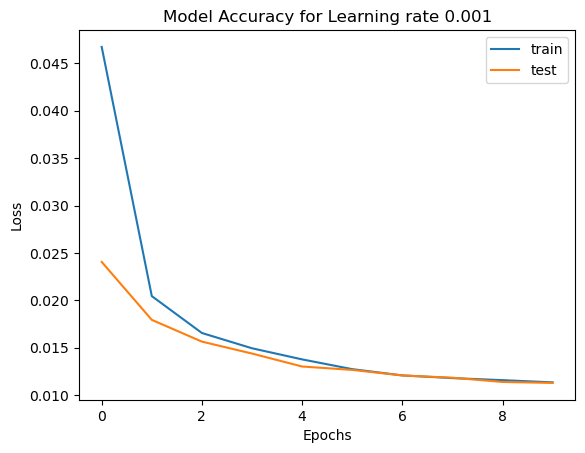

Epoch 1/10
57/57 [==============================] - 102s 2s/step - loss: 0.0508 - val_loss: 0.0315
Epoch 2/10
57/57 [==============================] - 102s 2s/step - loss: 0.0229 - val_loss: 0.0202
Epoch 3/10
57/57 [==============================] - 103s 2s/step - loss: 0.0188 - val_loss: 0.0180
Epoch 4/10
57/57 [==============================] - 103s 2s/step - loss: 0.0172 - val_loss: 0.0168
Epoch 5/10
57/57 [==============================] - 103s 2s/step - loss: 0.0164 - val_loss: 0.0163
Epoch 6/10
57/57 [==============================] - 103s 2s/step - loss: 0.0160 - val_loss: 0.0158
Epoch 7/10
57/57 [==============================] - 103s 2s/step - loss: 0.0158 - val_loss: 0.0155
Epoch 8/10
57/57 [==============================] - 103s 2s/step - loss: 0.0155 - val_loss: 0.0152
Epoch 9/10
57/57 [==============================] - 104s 2s/step - loss: 0.0165 - val_loss: 0.0145
Epoch 10/10
57/57 [==============================] - 103s 2s/step - loss: 0.0139 - val_loss: 0.0142


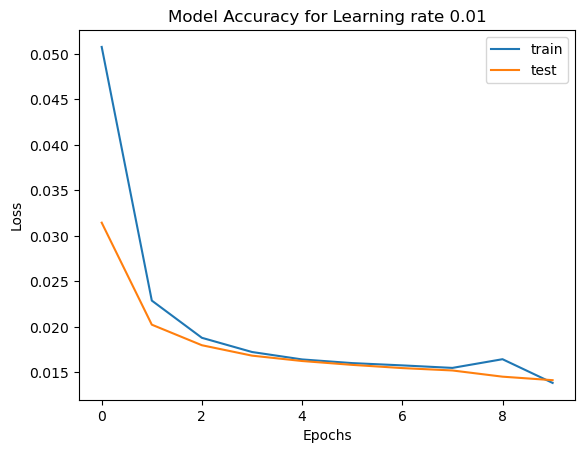

In [227]:
lr_params = [1e-4, 1e-3, 1e-2]

for lr in lr_params:
    buf = create_autoencoder(lr)
    history = buf.fit(
    train_generator,
    steps_per_epoch=train_generator.n//batch_size,
    validation_data=valid_generator,
    validation_steps=valid_generator.n//batch_size,
    epochs=10,
    verbose=1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Accuracy for Learning rate ' + str(lr))
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(['train', 'test'])
    plt.show()

In [228]:
model = create_autoencoder(0.001)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', mode='min', patience=5, restore_best_weights=True)

model.fit(
    train_generator,
    steps_per_epoch=train_generator.n//batch_size,
    validation_data=valid_generator,
    validation_steps=valid_generator.n//batch_size,
    epochs=30,
    verbose=1, callbacks=[early_stopping])

Epoch 1/30
57/57 [==============================] - 106s 2s/step - loss: 0.0559 - val_loss: 0.0303
Epoch 2/30
57/57 [==============================] - 104s 2s/step - loss: 0.0229 - val_loss: 0.0222
Epoch 3/30
57/57 [==============================] - 104s 2s/step - loss: 0.0187 - val_loss: 0.0170
Epoch 4/30
57/57 [==============================] - 103s 2s/step - loss: 0.0160 - val_loss: 0.0155
Epoch 5/30
57/57 [==============================] - 103s 2s/step - loss: 0.0143 - val_loss: 0.0136
Epoch 6/30
57/57 [==============================] - 102s 2s/step - loss: 0.0133 - val_loss: 0.0130
Epoch 7/30
57/57 [==============================] - 101s 2s/step - loss: 0.0128 - val_loss: 0.0125
Epoch 8/30
57/57 [==============================] - 103s 2s/step - loss: 0.0122 - val_loss: 0.0120
Epoch 9/30
57/57 [==============================] - 103s 2s/step - loss: 0.0118 - val_loss: 0.0117
Epoch 10/30
57/57 [==============================] - 103s 2s/step - loss: 0.0116 - val_loss: 0.0117
Epoch 11/

# Query Image

### Encoder from Autoencoder

In [231]:
encoder = Model(inputs=model.input, outputs=model.get_layer('encoder').output)
encoder.save(os.curdir + '/task2_model')

INFO:tensorflow:Assets written to: ./task2_model\assets


INFO:tensorflow:Assets written to: ./task2_model\assets


In [12]:
from keras.models import load_model

encoder = load_model(os.curdir + '/task2_model')

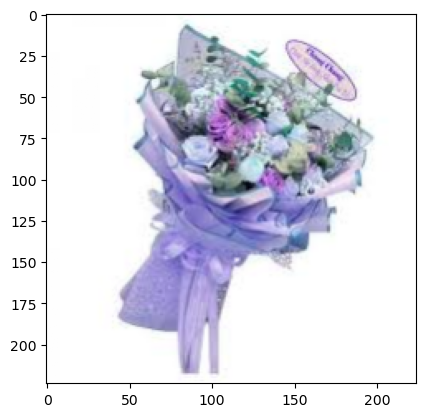

In [24]:
random_image = np.random.randint(len(X))
query = X[random_image]
plt.imshow(query)


In [25]:
codes = encoder.predict(X)

query_code = encoder.predict(query.reshape(1,224,224,3))


1/1 [==============================] - 0s 29ms/step


In [23]:
from sklearn.neighbors import NearestNeighbors
knn = NearestNeighbors(n_neighbors=11, metric="cosine")

In [26]:
codes = codes.reshape(-1, 56*56*8); print(codes.shape)
query_code = query_code.reshape(1, 56*56*8); print(query_code.shape)

(4621, 25088)
(1, 25088)


In [27]:
nbrs = knn.fit(codes)


In [28]:
distances, indices = nbrs.kneighbors(np.array(query_code))


In [29]:
closest_images = X[indices]


In [30]:
closest_images = closest_images.reshape(-1,224,224,3); print(closest_images.shape)


(11, 224, 224, 3)


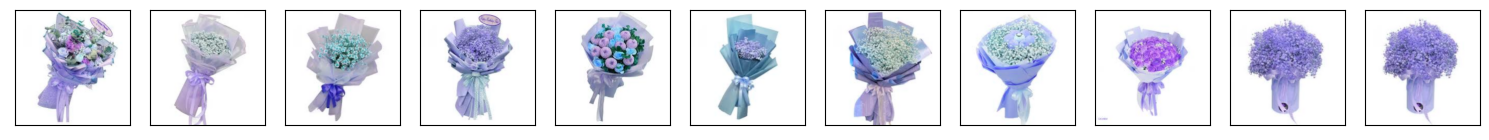

In [31]:
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(11):
    ax = plt.subplot(1, 11, i+1)
    plt.imshow(closest_images[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
        
plt.tight_layout()

### Extract encoder from Task 1 Model

In [32]:
task1_model = load_model(os.curdir + '/task1')

In [36]:
task1_model.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_92 (Conv2D)          (None, 224, 224, 32)      2432      
                                                                 
 max_pooling2d_72 (MaxPoolin  (None, 112, 112, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_93 (Conv2D)          (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_73 (MaxPoolin  (None, 56, 56, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_94 (Conv2D)          (None, 56, 56, 96)        55392     
                                                                 
 dropout_67 (Dropout)        (None, 56, 56, 96)      

In [33]:
task1_encoder = Model(inputs=task1_model.input, outputs=task1_model.get_layer('encoder').output)

In [34]:
codes = task1_encoder.predict(X)

query_code = task1_encoder.predict(query.reshape(1,224,224,3))

1/1 [==============================] - 0s 35ms/step


In [40]:
codes = codes.reshape(-1, 14*14*96); print(codes.shape)
query_code = query_code.reshape(1, 14*14*96); print(query_code.shape)

(4621, 18816)
(1, 18816)


In [41]:
nbrs = knn.fit(codes)


In [42]:
distances, indices = nbrs.kneighbors(np.array(query_code))


In [43]:
closest_images = X[indices]


In [44]:
closest_images = closest_images.reshape(-1,224,224,3); print(closest_images.shape)


(11, 224, 224, 3)


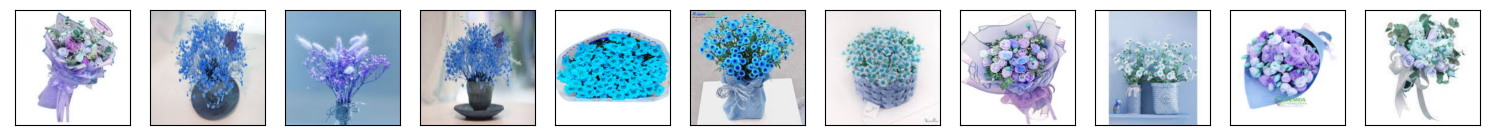

In [48]:
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(11):
    ax = plt.subplot(1, 11, i+1)
    plt.imshow(closest_images[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
        
plt.tight_layout()